In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score


from sklearn.pipeline import Pipeline
from copy import deepcopy


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from eli5.sklearn import PermutationImportance
import eli5
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler

from path import Path
import warnings 
warnings.filterwarnings('ignore') # supress warnings


In [2]:
# loading datasets
path = Path("/kaggle/input/playground-series-s3e12")

train = pd.read_csv(path / "train.csv")
test = pd.read_csv(path / "test.csv")
sub = pd.read_csv(path / "sample_submission.csv")
original = pd.read_csv("/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv")
original = original[train.drop('id', axis=1).columns.tolist()]

original = original.drop([5, 32]).reindex()


train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


<AxesSubplot:xlabel='calc', ylabel='count'>

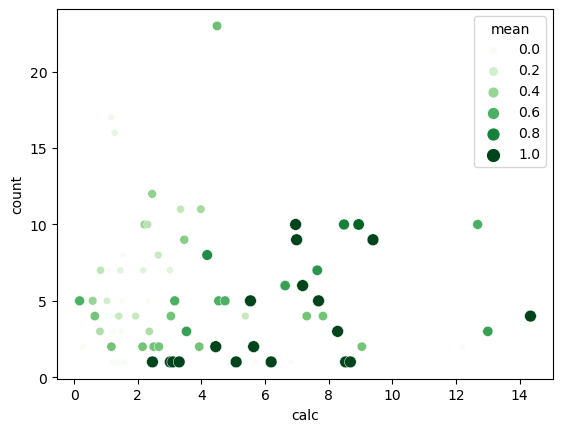

In [3]:
freq = train.groupby('calc').target.agg({'count', 'mean'})

sns.scatterplot(x=freq.index, y=freq['count'], hue=freq['mean'], size=freq['mean'], palette='Greens')

<AxesSubplot:xlabel='calc', ylabel='Count'>

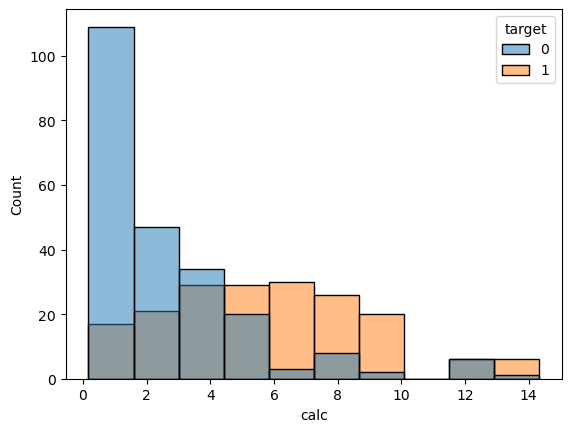

In [4]:
sns.histplot(data=train, x='calc', hue='target', bins=int(np.ceil(np.log2(len(train))+1)))

In [5]:
#  plot correaltion        
def plot_corr(df, features, target, sort=False, method='pearson', figsize=(13, 8), use_mask=True, mask_type="triu", **kwargs):
    """Plot correlation given dataset and features names"""
    plt.figure(figsize=figsize) # sets figure size
    corr = df[features].corr(method=method) # calculates correlation based on the features and method provied
    target_values = corr[target]
    features.remove(target)
    corr = corr[features]
    
    corr = pd.concat([corr, target_values], axis=1)
    
    if sort: # if sort is true then sort the correlation matrix
        corr = corr.sort_values(by=target)
    if use_mask: # if uses_mask = True
        if mask_type == 'triu': # sets mask type to lower trigonal
            mask = np.triu(np.ones(corr.shape)) 
        else:   # sets mask type to upper trigonal
            mask = np.tril(np.ones(corr.shape))
        sns.heatmap(corr, annot=True, mask=mask, **kwargs)
        
    else: # if uses mask is not true
         sns.heatmap(corr, annot=True, **kwargs)       

    plt.title('Correlation between features')

    
    
def submission_csv(_model, _train, _test, features):
    X_train = _train.drop(['id', 'target'], axis=1)[features]
    y_train = _train['target']
    X_test = _test.drop('id', axis=1)
    
    _model.fit(X_train, y_train)
    
    preds = _model.predict_proba(X_test)[:, 1]
    
    df = pd.DataFrame()
    df['id'] = _test['id']
    df['target'] = preds
    
    return 



def plot_importance(models, X_test, title=""):
#     taken from https://www.kaggle.com/code/shoabahamed/ps3e9-eda-and-gbdt-catboost-median-duplicatedata/edit
    """Plots features importance given models and train set"""
    features = X_test.columns.tolist()
    feature_importance = pd.DataFrame()
    for model in models:
        _df = pd.DataFrame()
        _df['importance'] = model.feature_importances_
        _df["features"] = pd.Series(features)
        _df = _df.sort_values(by='importance', ascending=False)
        feature_importance = pd.concat([feature_importance, _df])
        
                
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    plt.figure(figsize=(16, 10))
    ax = sns.barplot(x='importance', y='features', data=feature_importance, color='skyblue', errorbar='sd')
    
    for i in ax.containers:
        ax.bar_label(i,)
    
   
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f"{title} Feature Importances", fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    
    return feature_importance


class Splitter:
    """A splitter class which splits the X, y using the split_data function with a random state provided. It yeilds \
    X_train, X_val, y_train, y_val, train_idx, val_idx in the end.\
    code from  https://www.kaggle.com/code/tetsutani/ps3e9-eda-and-gbdt-catboost-median-duplicatedata wit little bit of modification """

    def __init__(self, test_size=0.2, kfold=True, n_splits=5, use_loocv=False):
        self.test_size = test_size # set test size
        self.kfold = kfold  # wheter to just split the data in two or use kfold
        self.n_splits= n_splits 
        self.use_loocv = use_loocv
        
    def split_data(self, X, y, random_state):
        if self.kfold:
            if self.use_loocv:
                kf = LeaveOneOut()
            else:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
            for train_idx, val_idx in kf.split(X, y):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                yield X_train, X_val, y_train, y_val, train_idx, val_idx
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
            yield X_train, X_val, y_train, y_val





def evaluate_model(model_name, model_pipeline, _X, _y, features, original_data=None, use_original=False, n_splits=5, random_state_list=[0, 5, 10], use_loocv=False):
    len_y = len(_y)
    len_states = len(random_state_list)

    oof_preds = np.zeros(len_y * len_states).reshape(len_states, len_y)
    scores_train = []
    model_pipelines = []

    for index, random_state in enumerate(random_state_list):
        print("#"*25)
        print("#"*15, f"traininng model {model_name} with seed {random_state}")
        print("#"*25)
        splitter = Splitter(n_splits=n_splits, use_loocv=use_loocv)
        splits = 0
        for X_train, X_val, y_train, y_val, train_idx, val_idx in splitter.split_data(_X, _y, random_state):
            if use_original: # we will only use original data for training not testing
                target = 'target'
                X_train = pd.concat([X_train, original_data.drop(target, axis=1)]) 
                y_train = pd.concat([y_train, original_data[target]])  

            model_pipeline.fit(X_train, y_train)
            if model_name.find('gam') != -1:
                oof_preds[index, val_idx] = model_pipeline.predict_proba(X_val).squeeze()
                score_train = roc_auc_score(y_train, model_pipeline.predict_proba(X_train))
            else:
                oof_preds[index, val_idx] = model_pipeline.predict_proba(X_val)[:, 1].squeeze()
                score_train = roc_auc_score(y_train, model_pipeline.predict_proba(X_train)[:, 1])
                
            scores_train.append(score_train)
            model_pipelines.append(deepcopy(model_pipeline))

            
    oof_preds_mean = oof_preds.mean(axis=0)

    return model_pipelines, oof_preds_mean, np.mean(scores_train), roc_auc_score(_y, oof_preds.mean(axis=0))


def predict_test(model_pipeline, X_test):
    test_preds = model_pipeline.predict_proba(X_test)[:, 1]
    return test_preds


# SVC

have the mindset that only some features would be better for particular models. Here we will only try to find the best features for SVC

****Baseline SVC score****

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [7]:
X = train.drop(['id', 'target'], axis=1)
y = train['target']
features = X.columns.tolist()
n_splits = 100
random_states = [0]

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])

_pipes, _oof_preds, _train_score, _oof_score = evaluate_model(f"pipeline_svc", pipe, X, y, features,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

#########################
############### traininng model pipeline_svc with seed 0
#########################


In [8]:
_oof_score

0.7821361058601133

This is our baseline score. We will start by adding features as we go

In [9]:
from itertools import combinations
cols = train.drop(['id', 'target'], axis=1).columns.tolist()

all_comb = []

for i in range(1, len(cols)+1):
    combs = list(combinations(cols, i))
    all_comb += combs
    
all_comb = [list(comb) for comb in all_comb]

In [10]:
svc_log = pd.DataFrame(columns=['features', 'train_score', 'valid_score', 'cv_gap'])
lr_log = pd.DataFrame(columns=['features', 'train_score', 'valid_score', 'cv_gap'])
rf_log = pd.DataFrame(columns=['features', 'train_score', 'valid_score', 'cv_gap'])
xgb_log = pd.DataFrame(columns=['features', 'train_score', 'valid_score', 'cv_gap'])
gb_log = pd.DataFrame(columns=['features', 'train_score', 'valid_score', 'cv_gap'])
knn_log = pd.DataFrame(columns=['features', 'train_score', 'valid_score', 'cv_gap'])
gam_log = pd.DataFrame(columns=['features', 'train_score', 'valid_score', 'cv_gap'])

In [11]:
# # with only calc feature
# train_temp = train.copy()

# for comb in all_comb:
#     X_temp = train_temp[comb]
#     y_temp = train_temp['target']
#     features_temp = X_temp.columns.tolist()
    
#     print(f'trained with {comb} features')
#     pipe = Pipeline(steps=[
#         ("scale", StandardScaler()),
#         ("model", SVC(probability=True, random_state=0))
#     ])

#     _pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_svc", pipe, X_temp, y_temp, features_temp,
#                                              use_original=False,
#                                              n_splits=n_splits, random_state_list=random_states, use_loocv=False)

#     svc_log = svc_log.append({'features': features_temp, 'train_score': _train_score_temp,
#                     'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)

In [12]:
# svc_log.sort_values(by=['cv_gap']).head()
best_svc_feats = ['ph', 'calc']

In [13]:
svc_log.sort_values(by=['valid_score'], ascending=False).head()
# best feature ph and calc

,features,train_score,valid_score,cv_gap


In [14]:
roc_auc_score(train['target'], train['calc'])

0.7916351606805293

In [15]:
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import PolynomialFeatures

In [16]:
train_temp = train.copy()
X_temp = train_temp[best_svc_feats]
y_temp = train_temp['target']
features_temp = X_temp.columns.tolist()

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_svc", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)


svc_log = svc_log.append({'features': features_temp, 'train_score': _train_score_temp,
                'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)
_oof_score_temp

#########################
############### traininng model pipeline_svc with seed 0
#########################


0.8001299621928166

In [17]:
features_temp = ['ph', 'calc']
X_temp = train_temp[best_svc_feats]
y_temp = train_temp['target']

X_temp['ph/calc'] = X_temp['ph']/X_temp['calc']
features_temp = X_temp.columns.tolist()

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_svc", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)


svc_log = svc_log.append({'features': features_temp, 'train_score': _train_score_temp,
                'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)

_oof_score_temp

#########################
############### traininng model pipeline_svc with seed 0
#########################


0.8054938563327032

In [18]:
features_temp = ['ph', 'calc']
X_temp = train_temp[best_svc_feats]
y_temp = train_temp['target']

X_temp['calc**2'] = X_temp['calc'] ** 2
X_temp['ph/calc'] = X_temp['ph']/X_temp['calc']

features_temp = X_temp.columns.tolist()

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_svc", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

svc_log = svc_log.append({'features': features_temp, 'train_score': _train_score_temp,
                'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)

_oof_score_temp

#########################
############### traininng model pipeline_svc with seed 0
#########################


0.8058246691871456

In [19]:
X_temp = train_temp[best_svc_feats]
y_temp = train_temp['target']

X_temp['ph**2'] = (X_temp['ph']) ** 2
X_temp['ph/calc'] = X_temp['ph']/X_temp['calc']

features_temp = X_temp.columns.tolist()
pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_svc", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

# svc_log = svc_log.append({'features': features_temp, 'train_score': _train_score_temp,
#                 'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)
_oof_score_temp

#########################
############### traininng model pipeline_svc with seed 0
#########################


0.8117911153119092

In [20]:
X_temp = train_temp[best_svc_feats]
y_temp = train_temp['target']

X_temp['ph**3'] = (X_temp['ph']) ** 3
X_temp['ph/calc'] = (X_temp['ph'])/X_temp['calc']

features_temp = X_temp.columns.tolist()

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_svc", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

svc_log = svc_log.append({'features': features_temp, 'train_score': _train_score_temp,
                'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)

_oof_score_temp

#########################
############### traininng model pipeline_svc with seed 0
#########################


0.8120274102079394

In [21]:
svc_log.sort_values(by='valid_score', ascending=False)

,features,train_score,valid_score,cv_gap
3,"[ph, calc, ph**3, ph/calc]",0.837028,0.812027,0.025001
2,"[ph, calc, calc**2, ph/calc]",0.834697,0.805825,0.028872
1,"[ph, calc, ph/calc]",0.837183,0.805494,0.031689
0,"[ph, calc]",0.829453,0.800130,0.029323


So our best features are [ph, calc, ph**2, ph/calc]

Manually hyperparameter tuning svc

In [22]:
X_temp = train_temp[best_svc_feats]
y_temp = train_temp['target']

X_temp['ph**3'] = (X_temp['ph']) ** 3
X_temp['ph/calc'] = (X_temp['ph'])/X_temp['calc']

features_temp = X_temp.columns.tolist()

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_svc", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

_train_score_temp, _oof_score_temp, (_train_score_temp-_oof_score_temp)

#########################
############### traininng model pipeline_svc with seed 0
#########################


(0.8370282122761948, 0.8120274102079394, 0.02500080206825539)

so default parameters are giving us the best result for svc

## LogisticRegression

In [23]:
best_lr_features = ['gravity', 'calc']

lr_log.sort_values(by='valid_score', ascending=False).head()

,features,train_score,valid_score,cv_gap


In [24]:
train_temp = train.copy()
X_temp = train_temp[best_lr_features]
y_temp = train_temp['target']

X_temp['calc**3'] = X_temp['calc'] ** 3
X_temp['gravity/calc'] = X_temp['gravity'] / X_temp['calc'] 



features_temp = X_temp.columns.tolist()

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", LogisticRegression(random_state=0))
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_lr", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

lr_log = lr_log.append({'features': features_temp, 'train_score': _train_score_temp,
                'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)

#########################
############### traininng model pipeline_lr with seed 0
#########################


hyperparamters

In [25]:
train_temp = train.copy()
X_temp = train_temp[best_lr_features]
y_temp = train_temp['target']

X_temp['calc**3'] = X_temp['calc'] ** 3
X_temp['gravity/calc'] = X_temp['gravity'] / X_temp['calc'] 

features_temp = X_temp.columns.tolist()

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", LogisticRegression(random_state=0))
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_lr", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

_train_score_temp, _oof_score_temp, (_train_score_temp-_oof_score_temp)
# best till now

#########################
############### traininng model pipeline_lr with seed 0
#########################


(0.8097350217538923, 0.7959593572778828, 0.01377566447600953)

## RF

In [26]:
best_rf_features = ['gravity', 'ph', 'cond', 'urea', 'calc']
# max_features=2, min_samples_split=5

Do not think that adding random forest is a good idea to ensemble

knn

In [27]:
# # with only calc feature
# train_temp = train.copy()

# for index, comb in enumerate(all_comb):
#     X_temp = train_temp[comb]
#     y_temp = train_temp['target']
#     features_temp = X_temp.columns.tolist()
    
#     print(f'index {index}trained with {comb} features')
#     pipe = Pipeline(steps=[
#         ("scale", StandardScaler()),
#         ("model", KNeighborsClassifier())
#     ])

#     _pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_knn", pipe, X_temp, y_temp, features_temp,
#                                              use_original=False,
#                                              n_splits=n_splits, random_state_list=random_states, use_loocv=False)

#     knn_log = knn_log.append({'features': features_temp, 'train_score': _train_score_temp,
#                     'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)

In [28]:
knn_log.sort_values('valid_score', ascending=False).head()

,features,train_score,valid_score,cv_gap


In [29]:
best_knn_features = ['gravity', 'ph', 'calc']

In [30]:
'ball_tree', 'kd_tree', 'brute'

('ball_tree', 'kd_tree', 'brute')

In [31]:
from sklearn.preprocessing import FunctionTransformer

In [32]:
# with only calc feature
train_temp = train.copy()

X_temp = train_temp[['cond', 'calc']]
y_temp = train_temp['target']
features_temp = X_temp.columns.tolist()


pipe = Pipeline(steps=[
    ('func', FunctionTransformer(lambda X: X * np.array([[0.01, 1]]))),
    ("scale", StandardScaler()),
    ("model", KNeighborsClassifier())
])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_knn", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

knn_log = knn_log.append({'features': features_temp, 'train_score': _train_score_temp,
                'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)

#########################
############### traininng model pipeline_knn with seed 0
#########################


gradient Boositing

In [33]:
best_gb_features = ['ph', 'cond', 'calc']

In [34]:
# with only calc feature
train_temp = train.copy()

X_temp = train_temp[best_gb_features]
y_temp = train_temp['target']
features_temp = X_temp.columns.tolist()


pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", GradientBoostingClassifier(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=2,
                                         min_weight_fraction_leaf=0.15))])

_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_knn", pipe, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)
# gb_log = gb_log.append({'features': features_temp, 'train_score': _train_score_temp,
#                 'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)
_oof_score_temp

#########################
############### traininng model pipeline_knn with seed 0
#########################


0.7852906427221171

In [35]:
_oof_score_temp

0.7852906427221171

In [36]:
gb_log

,features,train_score,valid_score,cv_gap


## GAM

In [37]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.0 MB/s eta 0:00:00


In [38]:
from pygam import GAM, LinearGAM, s, f, te ,LogisticGAM

In [39]:
# train_temp = train.copy()

# for comb in all_comb:
#     try:
#         X_temp = train_temp[comb]
#         y_temp = train_temp['target']
#         features_temp = X_temp.columns.tolist()

#         print(f'trained with {comb} features')

#         pipe = Pipeline(steps=[
#             ("scale", StandardScaler()),
#             ("model", LogisticGAM(verbose=False))])


#         _pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_gam", pipe, X_temp, y_temp, features_temp,
#                                                  use_original=False, n_splits=n_splits, random_state_list=random_states, use_loocv=False)
                                                                                          
#         gam_log = gam_log.append({'features': features_temp, 'train_score': _train_score_temp,
#                         'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)                                                                                
#     except:
#         continue

In [40]:
best_gam_features = ['cond', 'calc']

In [41]:
gam_log.sort_values(by='valid_score').tail()

,features,train_score,valid_score,cv_gap


In [42]:
X_temp = train_temp[best_gam_features]

pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", LogisticGAM(verbose=False, n_splines=[10, 25], lam=0.6))])



_pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_gam", pipe, X_temp, y_temp, features_temp,
                                         use_original=False, n_splits=n_splits, random_state_list=random_states, use_loocv=False)

# gam_log = gam_log.append({'features': features_temp, 'train_score': _train_score_temp,
#                 'valid_score': _oof_score_temp, 'cv_gap':(_train_score_temp-_oof_score_temp)}, ignore_index=True)          
_train_score_temp, _oof_score_temp, (_train_score_temp-_oof_score_temp)

#########################
############### traininng model pipeline_gam with seed 0
#########################


(0.8391867028534695, 0.8082939508506617, 0.030892752002807833)

In [43]:
# train_temp = train.copy()
# # features calc, cond
# X_temp = train[['calc', 'cond', 'urea']]
# X_temp['urea'] = pd.qcut(train['urea'], q=10)
# y_temp = train['target']
# features_temp = X_temp.columns.tolist()

# transformers = ColumnTransformer(transformers=[("poly", make_pipeline(PolynomialFeatures(degree=2, include_bias=False, interaction_only=True), 
#                                                         StandardScaler()),['calc', 'cond']), 
#                                                    ('ohe', OneHotEncoder(sparse=False, drop='first'), ['urea'])],
#                                                  remainder='passthrough')

# pipe = make_pipeline(transformers, SVC(probability=True, random_state=0))


# _pipes_temp, _oof_preds_temp, _train_score_temp, _oof_score_temp = evaluate_model(f"pipeline_svc", pipe, X_temp, y_temp, features_temp,
#                                          use_original=False,
#                                          n_splits=n_splits, random_state_list=random_states, use_loocv=False)

<AxesSubplot:ylabel='calc'>

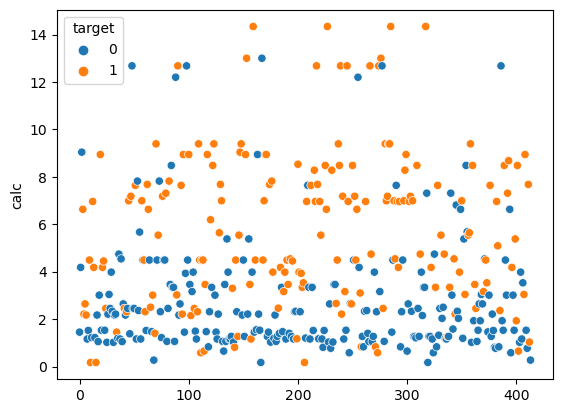

In [44]:
sns.scatterplot(x=range(len(train)), y=train['calc'], hue=train['target'])

In [45]:
train_temp = train.copy()


X_temp = train_temp[best_svc_feats]
y_temp = train_temp['target']

X_temp['ph**3'] = (X_temp['ph']) ** 3
X_temp['ph/calc'] = (X_temp['ph'])/X_temp['calc']

features_temp = X_temp.columns.tolist()

pipe_svc = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])

_pipes_svc, _oof_preds_svc, _train_score_svc, _oof_score_svc = evaluate_model(f"pipeline_svc", pipe_svc, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)


X_temp = train_temp[best_lr_features]
y_temp = train_temp['target']

X_temp['calc**3'] = X_temp['calc'] ** 3
X_temp['gravity/calc'] = X_temp['gravity'] / X_temp['calc'] 

features_temp = X_temp.columns.tolist()

pipe_lr = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", LogisticRegression(random_state=0))
])

_pipes_lr, _oof_preds_lr, _train_score_lr, _oof_score_lr = evaluate_model(f"pipeline_lr", pipe_lr, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)



X_temp = train_temp[best_knn_features]
y_temp = train_temp['target']
features_temp = X_temp.columns.tolist()


pipe_knn = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", KNeighborsClassifier())
])

_pipes_knn, _oof_preds_knn, _train_score_knn, _oof_score_knn = evaluate_model(f"pipeline_knn", pipe_knn, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)



X_temp = train_temp[best_gb_features]
y_temp = train_temp['target']
features_temp = X_temp.columns.tolist()


pipe_gb = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", GradientBoostingClassifier(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=2,
                                         min_weight_fraction_leaf=0.15))])

_pipes_gb, _oof_preds_gb, _train_score_gb, _oof_score_gb = evaluate_model(f"pipeline_gb", pipe_gb, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)


X_temp = train_temp[best_gam_features]

pipe_gam = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", LogisticGAM(verbose=False, n_splines=[10, 25], lam=0.6))])


_pipes_gam, _oof_preds_gam, _train_score_gam, _oof_score_gam = evaluate_model(f"pipeline_gam", pipe_gam, X_temp, y_temp, features_temp,
                                         use_original=False,
                                         n_splits=n_splits, random_state_list=random_states, use_loocv=False)

#########################
############### traininng model pipeline_svc with seed 0
#########################
#########################
############### traininng model pipeline_lr with seed 0
#########################
#########################
############### traininng model pipeline_knn with seed 0
#########################
#########################
############### traininng model pipeline_gb with seed 0
#########################
#########################
############### traininng model pipeline_gam with seed 0
#########################


In [46]:
preds = (_oof_preds_svc + _oof_preds_gb + _oof_preds_knn + _oof_preds_lr + _oof_preds_gam) / 5

roc_auc_score(train['target'], preds)

0.8176039697542533

In [47]:
preds = (_oof_preds_svc + _oof_preds_gam) / 2

roc_auc_score(train['target'], preds)

0.8167769376181475

In [48]:
X = pd.DataFrame()
X['svc'] = _oof_preds_svc
X['lr'] = _oof_preds_lr
X['knn'] = _oof_preds_knn
X['gb'] = _oof_preds_gb
X['gam'] = _oof_preds_gam

In [49]:
blend = LogisticRegression()
blend.fit(X, train['target'])

LogisticRegression()

In [50]:
coef = blend.coef_[0]

In [51]:
preds = (X['svc'] * coef[0] + X['lr'] * coef[1] + X['knn'] * coef[2] + X['gb'] * coef[3] + X['gam'] * coef[4]) / coef.sum()

In [52]:
roc_auc_score(train['target'], preds)

0.8194470699432892

In [53]:
def submission_csv(_model, _train, _y, _test, features, gam=False):
    X_train = _train[features]
    y_train = _y
    X_test = _test.drop('id', axis=1)[features]
    _model.fit(X_train, y_train)
    if gam:
        preds = _model.predict_proba(X_test)
    else:
        preds = _model.predict_proba(X_test)[:, 1]

    df = pd.DataFrame()
    df['id'] = _test['id']
    df['target'] = preds

    return df


In [54]:
test['ph**3'] = (test['ph']) ** 3
test['ph/calc'] = (test['ph'])/test['calc']

test['calc**3'] = X_temp['calc'] ** 3
test['gravity/calc'] = test['gravity'] / test['calc'] 

In [55]:
X_temp = train_temp[best_svc_feats]
y_temp = train_temp['target']

X_temp['ph**3'] = (X_temp['ph']) ** 3
X_temp['ph/calc'] = (X_temp['ph'])/X_temp['calc']


features_temp = X_temp.columns.tolist()

pipe_svc = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", SVC(probability=True, random_state=0))
])


svc_df = submission_csv(pipe_svc, X_temp, y_temp, test, features_temp)

X_temp = train_temp[best_lr_features]
y_temp = train_temp['target']

X_temp['calc**3'] = X_temp['calc'] ** 3
X_temp['gravity/calc'] = X_temp['gravity'] / X_temp['calc'] 

features_temp = X_temp.columns.tolist()

pipe_lr = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", LogisticRegression(random_state=0))
])


lr_df = submission_csv(pipe_svc, X_temp, y_temp, test, features_temp)

X_temp = train_temp[best_knn_features]
y_temp = train_temp['target']
features_temp = X_temp.columns.tolist()


pipe_knn = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", KNeighborsClassifier())
])


knn_df = submission_csv(pipe_knn, X_temp, y_temp, test, features_temp)

X_temp = train_temp[best_gb_features]
y_temp = train_temp['target']
features_temp = X_temp.columns.tolist()


pipe_gb = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", GradientBoostingClassifier(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=2,
                                         min_weight_fraction_leaf=0.15))])


gb_df = submission_csv(pipe_gb, X_temp, y_temp, test, features_temp)

X_temp = train_temp[best_gam_features]

features_temp = X_temp.columns.tolist()

pipe_gam = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("model", LogisticGAM(verbose=False, n_splines=[10, 25], lam=0.6))])


gam_df = submission_csv(pipe_gam, X_temp, y_temp, test, features_temp, gam=True)

In [56]:
preds = (svc_df['target'] * coef[0] + lr_df['target']  * coef[1] 
         + knn_df['target']  * coef[2] + gb_df['target'] * coef[3] + gam_df['target']  * coef[4]) / coef.sum()

In [57]:
blend_df = svc_df.copy()
blend_df['target'] = preds

In [58]:
svc_df.to_csv("svc_df.csv", index=False)
gam_df.to_csv("gam_df.csv", index=False)
blend_df.to_csv("blend_df.csv", index=False)